In [1]:
import pathlib
import json
import shutil
import os

from IPython.display import Image as DImage
from IPython.display import IFrame
import plotly.graph_objects as go
import numpy as np
import torch
import trimesh
from omegaconf import OmegaConf

from training.data import SimpleShapesDataset
from point_transformer.layers import PointTransformerLayer

In [2]:
%load_ext tensorboard
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

from notebook_utils import load_network, load_val_dataloader, compute_embeddings

# MADE Графовые нейронных сети для работы с 3D

![logo](media/logo.svg)

## Введение

Постоянный рост и упрощение способа получения разнообразных данных требует разработки и улучшения методов автоматического анализа таких данных. В докладе рассмотрим как можно обрабатывать 3D данные на примере облаков точек. 

### Актуальные приложения

#### AR/VR дополненная и виртуальна реальность

Сканирование в очках дополненной реальности на примере HoloLens

In [4]:
DImage(url="https://images.techhive.com/images/article/2016/03/hololens-scanning-100652561-large.png?auto=webp&quality=85,70", width=500)

IPad Pro with Lidar

In [5]:
DImage(url="https://i.ytimg.com/vi/fS3J4V_BgP0/maxresdefault.jpg", width=500)

#### 3D сканирование

In [6]:
DImage(url="http://digiwarestore.com/img/cms/berita/apa-itu-lidar/1.jpg", width=500)

In [7]:
DImage(url="https://www.secuteck.ru/hubfs/SecuteckRu/Articles/LiDAR_detection%20matrix_%C2%A9LeddarTech.jpg", width=500)

## Основные способы представления 3D данных

In [8]:
example_model = trimesh.load("./media/chebur.obj")

### Полигональная модель

Достоинства:

* Удобно хранить
* Часто используется в 3D графике и оптимизировано для работы
* Достаточно компактное описание c точки зрения хранения

Недостатки:
* Приближённое представление
* Неоднозначность представления

In [9]:
example_model.show(viewer="notebook", width=300)

d:\AnacondaEnvs\point-transformer\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Облако точек

Достоинства:

* Просто хранить
* В таком виде данные получаются с устройств сканирования

Недостатки:
* Нет информации как точки связаны между собой
* Приближённое представление
* Для точного описание объекта нужно много точек

In [10]:
go.Figure(go.Scatter3d(x=example_model.vertices[:, 0], y=example_model.vertices[:, 1], z=example_model.vertices[:, 2], mode="markers", marker=dict(size=1)))

### Воксели

Достоинства:

* Просто хранить
* Структура представления похожа на 2D изображения

Недостатки:
* Грубое представление
* Может потребоваться большой объём памяти для хранения

In [11]:
example_model.voxelized(0.02).show(viewer="notebook")

d:\AnacondaEnvs\point-transformer\lib\site-packages\IPython\core\display.py:419: UserWarning:

Consider using IPython.display.IFrame instead



### Функциональное представление (SDF)

Достоинства:

* Просто хранить
* Максимальное точное представление
* Можно получить аналитически дополнительные характеристики

Недостатки:
* Тяжело визуализировать 
* Необходимо дополнительные преобразования, чтобы получить представления, которые используются в приложениях

In [12]:
DImage(url="https://media.slid.es/uploads/918171/images/9546516/pasted-from-clipboard.png", width=500)

## Основные задачи обработки облака точек

[Deep Learning for 3D Point Clouds: A Survey](https://api.semanticscholar.org/CorpusID:209501181)

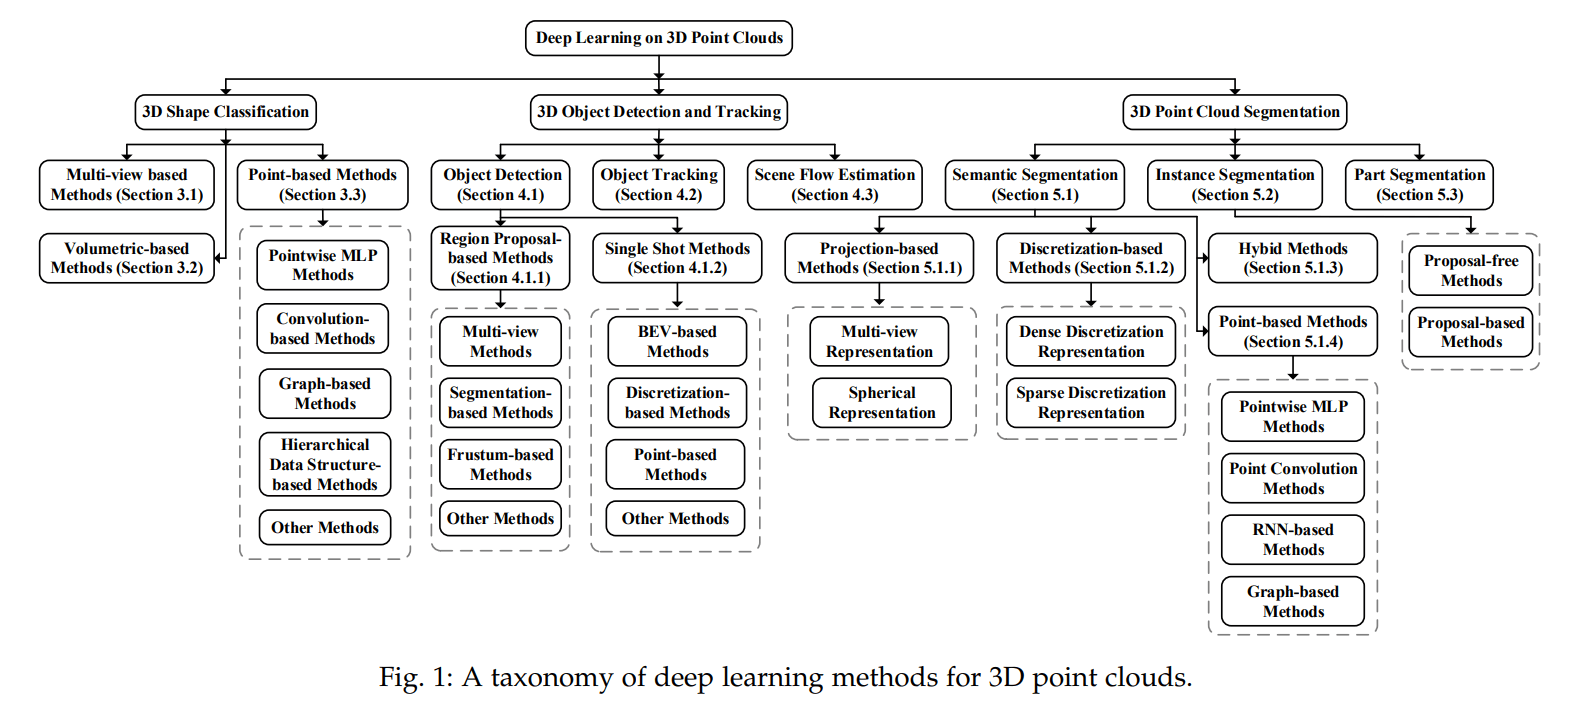

In [13]:
DImage(filename="./media/main_tasks.png", width=800)

## Представление облака точек

С точки зрения представления облако точек можно представить в виде матрицы $ \mathbb{R}^{N\mathrm{x}M} $, где $N-$ число точек, $M-$ число признаков для каждой точки (позиция, нормаль и т. п.).

### Как делали обрабатывали до нейронных сетей

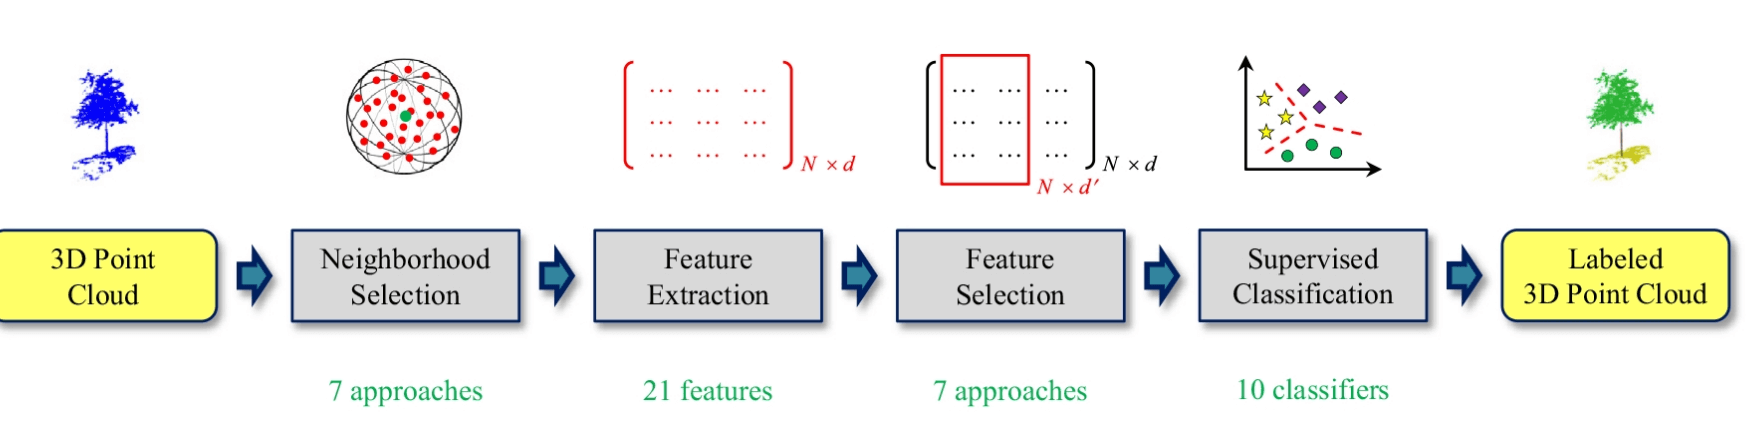

In [14]:
DImage(filename="./media/cls_pipeline.png", width=800)

### С приходом нейронных сетей

В одной из [ранних работ PointNet](https://api.semanticscholar.org/CorpusID:5115938) была предложена нейронная сеть для решения базовых задач: классификация, семантическая сегментация и т. п.

На вход она принимала множество точек в "естественном представлении".

В этой работе были выделены следующие свойства облака точек:
1. Представление неупорядоченно каким-либо образом. При перестановки строк в матрице представление объекта не меняется. Модель должна это как-то учитывать.
2. Связь между точками. Модель должна учитывать локальную структуру "близких" точек.
3. Инвариантность к преобразованиям. Некоторые преобразования такие как: повороты, параллельный перенос не должны менять результата работы сети.

## Где графы

В [Dynamic Graph CNN for Learning on Point Clouds](https://api.semanticscholar.org/CorpusID:94822) предложили использовать свёртки на графах. Граф строится динамически через KNN, но в простраснтве признаков. 

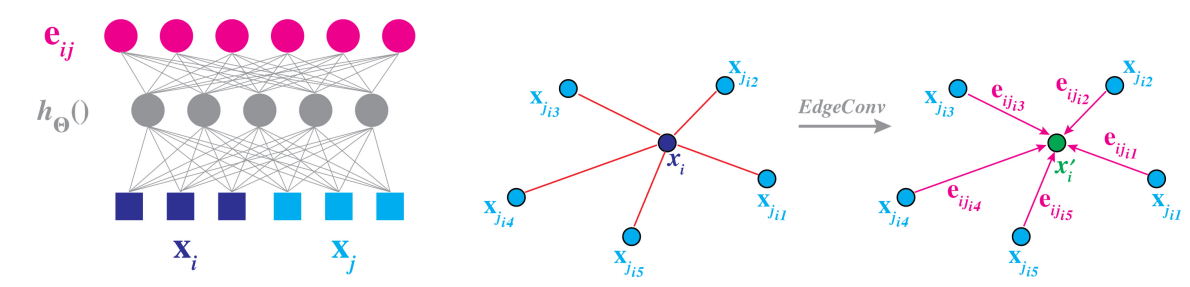

In [15]:
DImage(filename="./media/edge_conv.png", width=900)

Расстояние в пространстве признаков от красной точки: Евклидово расстояние в $\mathbb{R}^3$ (слева), расстояние после применения геометрического преобразования (центр), расстояние в пространстве признаков последнего слоя (справа).

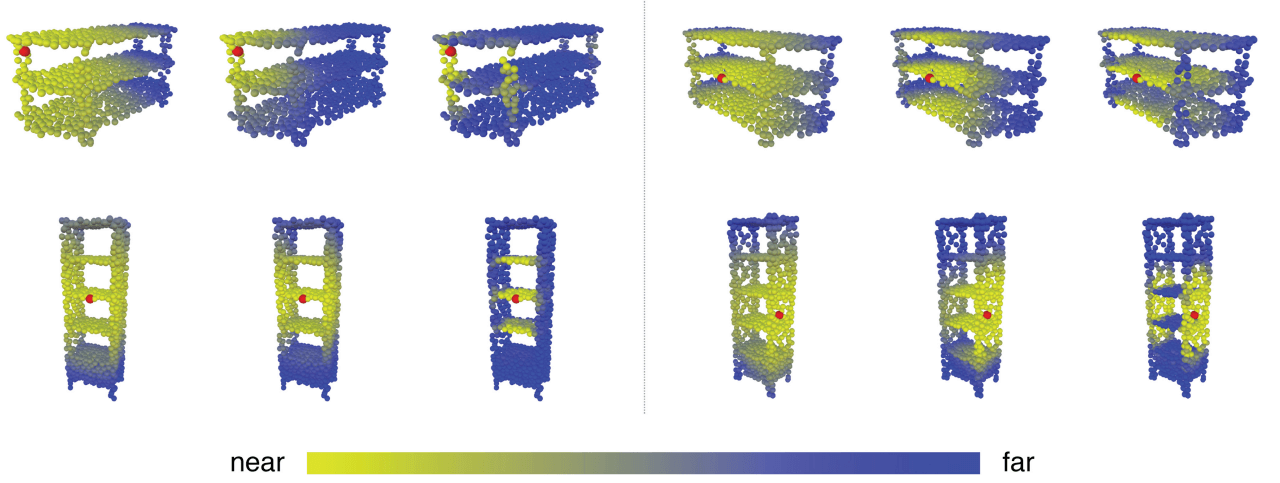

In [16]:
DImage(filename="./media/feature_space.png", width=900)

Если есть граф с признаками вершинами $x_i \in \mathbb{R}^m, i=1,\ldots,n, $ и признаками рёбер $ e_{ji} \in \mathbb{R}^l, i,j=1,\ldots, n$, то преобразование признаков на слое $k$ нейронной сети $x_i^{(k)} $ можно представить в виде:

\begin{equation}
x_i^{(k)} = \gamma^{(k)}\left( x_i^{(k-1)}, \square_{j \in N(i)} \phi^{(k)} \left(x_i^{(k-1)}, x_j^{(k-1)}, e_{ji}\right)  \right),
\end{equation}

шде $\gamma(\cdot,\cdot), \phi(\cdot,\cdot,\cdot)$-дифференциреумые функции, а $\square$- симметричная функция по всем аргументам, $N(i)-$ множество индексов соседей вершины с номером $i$.

## Практика

На практике можно использовать эти framework для ускорения работы:
1. [DGL](https://github.com/dmlc/dgl)
2. [PyTorch Geometric (далее рассмотрим)](https://github.com/pyg-team/pytorch_geometric)

В PyTorch Geometric Реализовано много различных вспомогательных функций для работы с облаком точек и графов. 

Для примера возьмём архитектуру [Point Transformer](https://api.semanticscholar.org/CorpusID:229220595)

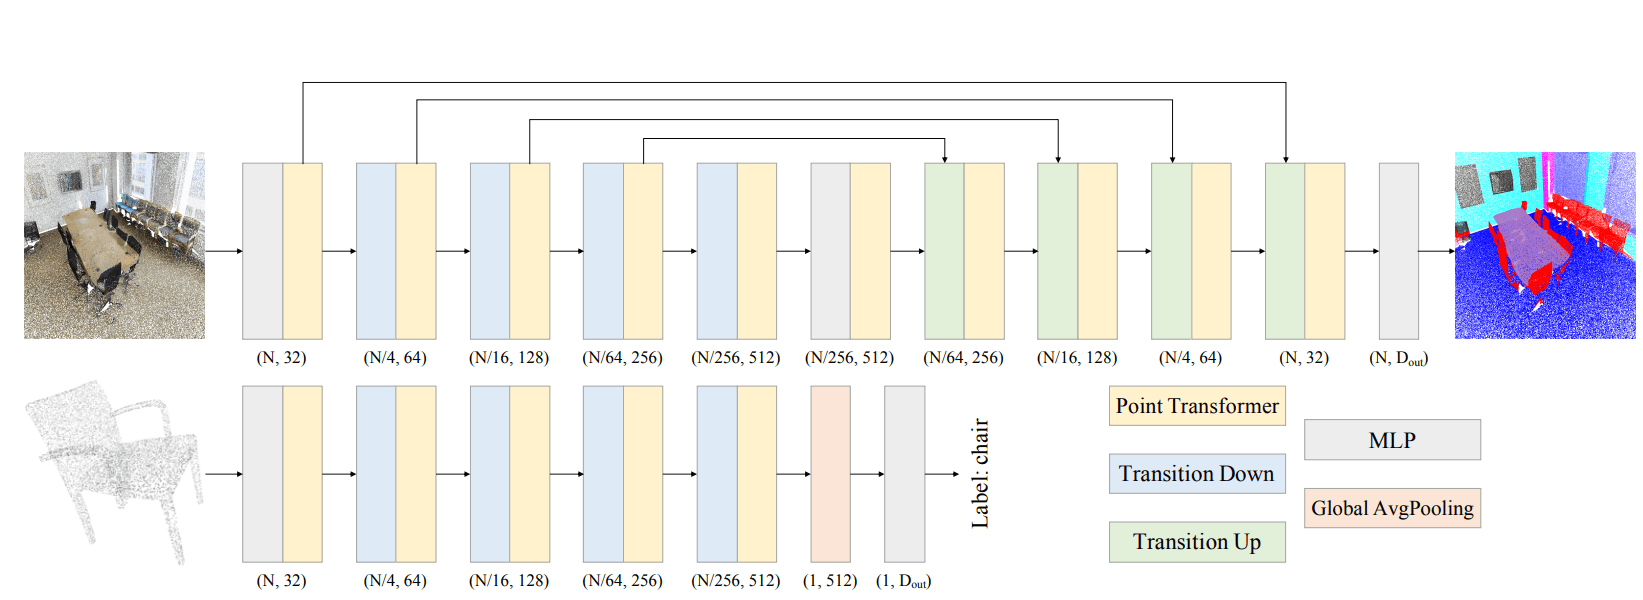

In [17]:
DImage(filename="./media/point-tr-net.png", width=1000)

В статье предлагается использовать следующую схему обновления весов:
\begin{equation}
x_i^{(k)} = \sum\limits_{j \in N(i)} \rho\left( \gamma\left( \phi\left(x_i^{(k-1)}\right) -\psi\left(x_j^{(k-1)}\right) + \delta \right)\right) \odot \left(\alpha\left(x_j^{(k-1)} + \delta\right) \right),
\end{equation}

где $\rho(\cdot)-$ функция нормализации (например softmax), $\odot$- поэлементное умножение, $\delta$- позиционное кодирование, $\gamma, \phi, \psi, \alpha$- функции для преобразования признаков (сети прямого распространения разной конфигурации).

То что было:
\begin{equation}
x_i^{(k)} = \gamma^{(k)}\left( x_i^{(k-1)}, \square_{j \in N(i)} \phi^{(k)} \left(x_i^{(k-1)}, x_j^{(k-1)}, e_{ji}\right)  \right),
\end{equation}

Реализация:

```python
class PointTransformerLayer(MessagePassing):
    propagate_type = {"x": torch.Tensor, "pos": torch.Tensor}

    def __init__(self, *,
                 in_features: int,
                 out_features: int,
                 num_neighbors: int,
                 gamma_mlp_hidden_dim: int = 32,
                 pos_encoder_hidden_dim: int = 32,
                 num_coords: int = 3):
        super().__init__(aggr="add")
        self.positional_encoder = PositionalEncoder(
            num_coords=num_coords, hid_dim=pos_encoder_hidden_dim, output_dim=out_features)
        self.phi = nn.Linear(in_features, out_features)
        self.psi = nn.Linear(in_features, out_features)
        self.alpha = nn.Linear(in_features, out_features)
        self.gamma = nn.Sequential(nn.Linear(out_features, gamma_mlp_hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(gamma_mlp_hidden_dim, out_features)
                                   )
        self.knn_num_neighs = num_neighbors
        self._out_features = out_features

    def forward(self, fpb_data: PointSetBatchInfo) -> PointSetBatchInfo:
        """features [N x in_features] - node features
           positions [N x num_coords] - position of points. By default num_coords is equal to 3.
           batch [N x 1] - batch indices
        """
        features, positions, batch = fpb_data
        edge_indices = knn_graph(features, k=self.knn_num_neighs,
                                 batch=batch, flow=self.flow, loop=False)
        new_features = self.propagate(edge_indices, x=features, pos=positions, size=None)
        return new_features, positions, batch

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, pos_i: torch.Tensor, pos_j: torch.Tensor) -> torch.Tensor:
        pos_encoding = self.positional_encoder(pos_i, pos_j)
        return F.softmax(self.gamma(self.phi(x_i) - self.psi(x_j) + pos_encoding),
                         dim=-1) * (self.alpha(x_j) + pos_encoding)
```

In [18]:
config_path = ".\exp\simple_shapes\exp\config\config.yaml"
config = OmegaConf.load(config_path)

model, pre_transforms, class_mapping, inv_class_mapping, device = load_network(config_path)

In [19]:
valid_dataloader = load_val_dataloader(config)

In [20]:
log_dir = "./demo_data/emb_logs"

compute_embeddings(log_dir, model, valid_dataloader, inv_class_mapping, device)

  0%|          | 0/34 [00:00<?, ?it/s]

In [22]:
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 9476), started 4 days, 0:37:15 ago. (Use '!kill 9476' to kill it.)